In [1]:
import cartopy.feature as feature
import cartopy.crs as ccrs
from calendar import month_abbr
import matplotlib.dates as mdates
from pathlib import Path 
import subprocess 
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import datetime
import numpy as np
import pandas as pd
import xarray
import xesmf
import os 
from glob import glob
from plot_common import autoextend_colorbar, corners, get_map_norm, open_var, add_ticks, annotate_skill, save_figure

In [2]:
def compute_gs(ssh, data_grid=None):
    lons = np.arange(360-72, 360-51.9, 1)
    lats = np.arange(36, 42, 0.1)
    target_grid = {'lat': lats, 'lon': lons}

    if data_grid is None:
        data_grid = {'lat': ssh.lat, 'lon': ssh.lon}

    ssh_to_grid = xesmf.Regridder(
        data_grid,
        target_grid,
        method='bilinear'
    )

    # Interpolate the SSH data onto the index grid.
    regridded = ssh_to_grid(ssh)

    # Find anomalies relative to the calendar month mean SSH over the full model run.
    anom = regridded.groupby('time.month') - regridded.groupby('time.month').mean('time')

    # For each longitude point, the Gulf Stream is located at the latitude with the maximum SSH anomaly variance.
    stdev = anom.std('time')
    amax = stdev.argmax('lat').compute()
    gs_points = stdev.lat.isel(lat=amax).compute()

    # The index is the mean latitude of the Gulf Stream, divided by the standard deviation of the mean latitude of the Gulf Stream.
    index = ((anom.isel(lat=amax).mean('lon')) / anom.isel(lat=amax).mean('lon').std('time')).compute()

    # Move times to the beginning of the month to match observations.
    monthly_index = index.to_pandas().resample('1MS').first()
    return monthly_index, gs_points


In [3]:
def open_var(pp_root, kind, var):
    freq = 'daily' if 'daily' in kind else 'monthly'
    longslice = '19930101-19981231' if freq == 'daily' else '199301-199812'
    longfile = os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.{longslice}.{var}.nc')
    if os.path.isfile(longfile):
        os.system(f'dmget {longfile}')
        return xarray.open_dataset(longfile)[var]
    elif len(glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '1yr', f'{kind}.*.{var}.nc'))) > 0:
        files = glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '1yr', f'{kind}.*.{var}.nc'))
        os.system(f'dmget {" ".join(files)}')
        return xarray.open_mfdataset(files)[var]
    elif len(glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.*.{var}.nc'))) > 0:
        files = glob(os.path.join(pp_root, 'pp', kind, 'ts', freq, '5yr', f'{kind}.*.{var}.nc'))
        os.system(f'dmget {" ".join(files)}')
        return xarray.open_mfdataset(files)[var]
    else:
        raise Exception('Did not find postprocessed files')

In [4]:
rootmed = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod') 
rootlow = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod')
rootobs = Path('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.nc') 
sstwholemed = open_var(rootmed, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
sstwholelow = open_var(rootlow, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
obs = xarray.open_mfdataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.nc')['sst']
obsgsipts = pd.read_pickle('/home/Andrew.C.Ross/git/nwa12/experiments/COBALT_2023_04/data/satellite_ssh_index.pkl').resample('1YS').mean()
model_grid = xarray.open_dataset('../data/geography/ocean_static.nc')
obs_grid = xarray.open_mfdataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.grid.nc')  

In [5]:
#OISST TO MOM 

obsregrd = xesmf.Regridder(obs_grid, {'lat': model_grid.geolat, 'lon': model_grid.geolon}, 
        method='bilinear', 
        unmapped_to_nan=True)

obs_regriddeda = obsregrd(obs)

In [6]:
obs_regridded = obs_regriddeda.sel(time=slice('1993','2007')) 

In [7]:
modelgsiindexmed, modelgsipointsmed = compute_gs(sstwholemed, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow, modelgsipointslow = compute_gs(sstwholelow, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexobs, modelgsipointsobs = compute_gs(obs_regridded, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order in

In [8]:
masks = xarray.open_dataset('/home/Andrew.C.Ross/git/nwa12/data/geography/masks/regions_30m.nc') 

In [9]:
masks.data_vars

Data variables:
    areacello  (yh, xh) float32 3MB ...
    geolat     (yh, xh) float32 3MB ...
    geolon     (yh, xh) float32 3MB ...
    MAB        (yh, xh) bool 655kB ...
    GOM        (yh, xh) bool 655kB ...
    SS         (yh, xh) bool 655kB ...
    GB         (yh, xh) bool 655kB ...
    SS_LME     (yh, xh) bool 655kB ...
    NEUS_LME   (yh, xh) bool 655kB ...
    SEUS_LME   (yh, xh) bool 655kB ...
    GOMEX      (yh, xh) bool 655kB ...
    Floridian  (yh, xh) bool 655kB ...
    GSL        (yh, xh) bool 655kB ...
    NGOMEX     (yh, xh) bool 655kB ...
    SGOMEX     (yh, xh) bool 655kB ...
    Antilles   (yh, xh) bool 655kB ...

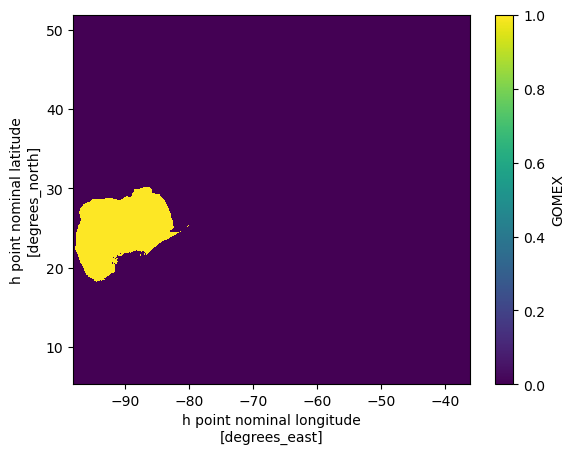

In [17]:
masks['GOMEX'].plot()

In [8]:
weights_gom = masks['areacello'].where(masks['GOM']).fillna(0) 
weights_neus = masks['areacello'].where(masks['NEUS_LME']).fillna(0)

In [ ]:
mean_sst_neus_med = sstwholemed.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low = sstwholelow.weighted(weights_neus).mean(['yh', 'xh']).compute() 

In [ ]:
mean_sst_neus_obs = obs_regridded.weighted(weights_neus).mean(['yh', 'xh'])

In [ ]:
mean_sst_gom_med = sstwholemed.weighted(weights_gom).mean(['yh', 'xh']).compute() 
mean_sst_gom_low = sstwholelow.weighted(weights_gom).mean(['yh', 'xh']).compute() 

In [ ]:
annual_gsi_index_med = modelgsiindexmed.resample('1YS').mean()
annual_gsi_index_low = modelgsiindexlow.resample('1YS').mean()
annual_gsi_index_obs = modelgsiindexobs.resample('1YS').mean() 
annual_gom_med = mean_sst_gom_med.resample(time='1YS').mean()
annual_gom_low = mean_sst_gom_low.resample(time='1YS').mean()
annual_neus_med = mean_sst_neus_med.resample(time='1YS').mean()
annual_neus_low = mean_sst_neus_low.resample(time='1YS').mean()
annual_neus_obs = mean_sst_neus_obs.resample(time='1YS').mean() 

In [ ]:
annual_neus_obs = mean_sst_neus_obs.resample(time='1YS').mean()

In [ ]:
annual_neus_obs.sel(time=slice('1995', '2007')) 

In [ ]:
pd.DataFrame.to_xarray(annual_gsi_index_obs)['time'] 

In [ ]:
annual_low_gom_corr = xarray.corr(annual_gom_low.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low), dim='time').item() 
annual_med_gom_corr = xarray.corr(annual_gom_med.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med), dim='time').item() 
annual_neus_low_corr = xarray.corr(annual_neus_low.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low), dim='time').item() 
annual_neus_med_corr = xarray.corr(annual_neus_med.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med), dim='time').item() 
annual_neus_obs_corr = xarray.corr(annual_neus_obs.sel(time=slice('1995', '2007')), pd.DataFrame.to_xarray(annual_gsi_index_obs), dim='time')

In [ ]:
annual_neus_obs_corr = xarray.corr(annual_neus_obs.sel(time=slice('1995', '2007')).load(), pd.DataFrame.to_xarray(annual_gsi_index_obs).sel(time=slice('1995', '2007')), dim='time')

In [ ]:
annual_neus_obs_corr

In [ ]:
x = annual_neus_obs.sel(time=slice('1995', '2007')).load()

In [ ]:
y = pd.DataFrame.to_xarray(annual_gsi_index_obs).sel(time=slice('1995', '2007'))

In [ ]:
xarray.corr(x,y,dim='time')

In [ ]:
annual_low_gom_corr

In [ ]:
annual_med_gom_corr

In [ ]:
annual_neus_low_corr

In [ ]:
annual_neus_med_corr

In [ ]:
annual_neus_obs_corr

In [ ]:
'''import xskillscore as xs

def plot_timeseries(ax, data, gsi_data, color, label, gsi_label):
    y = data.sel(epu=4).tos
    x = data.time.values
    x_gsi = gsi_data.time.values
    
    if 'member' in gsi_data.dims:
        y_gsi = gsi_data.mean(dim='member')
    else:
        y_gsi = gsi_data
        
    t = data.sel(time=slice('1993-01-01','2007-12-31')).time.values
    slope,intercept,r_value,p_value,std_err = stats.linregress(np.arange(len(t)),
                        y.sel(time=slice('1993-01-01','2007-12-31')).values)
    
    y_aligned, y_gsi_aligned = xr.align(y, y_gsi)

    # Calculate correlation and effective sample size
    corr = xs.pearson_r(y_aligned.sel(time=slice('1993','2022')), 
                        y_gsi_aligned.sel(time=slice('1993','2022')), dim='time')

    # Calculate p-value using adjusted degrees of freedom
    p_val_corr = xs.pearson_r_eff_p_value(y_aligned.sel(time=slice('1993','2022')), 
                                          y_gsi_aligned.sel(time=slice('1993','2022')), dim='time')

    ax.plot(x,y, c=color, alpha=0.5, label=label)
    ax.plot(x_gsi,y_gsi, c=color, linestyle='--', alpha=0.5, label=gsi_label)
    
    ax.text(0.1, 0.9, f'r (SST vs GSI) : {corr:.2f}', transform=ax.transAxes, fontsize=6)
    
    if p_val_corr < 0.05:
        ax.text(0.1, 0.8, f'p<0.05', transform=ax.transAxes, fontsize=6)
    else:
        ax.text(0.1, 0.8, f'p: {p_val_corr:.2f}', transform=ax.transAxes, fontsize=6)
        
    #ax.text(0.22, 0.85, f'Trend: {slope:.2f} °C/year', transform=ax.transAxes, fontsize=6)
    ax.legend(loc='lower left', fontsize='xx-small', frameon= False)
    ax.set_ylim(-3, 3)

ax9 = fig.add_subplot(4, 3, 3)
plot_timeseries(ax9, oisst_epu, satellite_gsi_norm, 'black', 'OISST', 'Altimeter_GSI')
ax10 = fig.add_subplot(4, 3, 6)
plot_timeseries(ax10, glorys_epu, glorys_gsi_norm, 'darkblue', 'GLORYS', 'GLORYS_GSI')
ax11 = fig.add_subplot(4, 3, 9)
plot_timeseries(ax11,spear_a1_epu, spear_a1_gsi_norm, '#648fff', 'SPEAR_LO','SPEAR_LO_GSI')
ax12 = fig.add_subplot(4, 3, 12)
plot_timeseries(ax12,nwa12_a1_epu, nwa12_a1_gsi_norm, '#fe6100', 'MOM6_NWA12','MOM6_NWA12_GSI')
ax12.tick_params(axis='x', labelsize=8)
ax12.set_xlabel('Year', fontsize=8)
'''

In [ ]:
nwa12_a1_gsi = xarray.open_dataset('/work/vnk/outdata_for_analysis/nwa12_a1_gsi.nc').__xarray_dataarray_variable__

In [ ]:
obsds = xarray.open_mfdataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.nc') 

In [ ]:
obsds['sst']

In [ ]:
nwa12_a1_gsi.mean(dim='member').sel(time=slice('1995','2007')).plot()
pd.DataFrame.to_xarray(annual_gsi_index_med).sel(time=slice('1995','2007')).plot() 
pd.DataFrame.to_xarray(annual_gsi_index_low).sel(time=slice('1995','2007')).plot() 

In [10]:
annual_neus_obs.plot() 

NameError: name 'annual_neus_obs' is not defined

In [ ]:
((annual_neus_med - annual_neus_med.mean('time'))/(annual_neus_med).std('time')).sel(time=slice('1995','2007')).plot() 
((pd.DataFrame.to_xarray(annual_gsi_index_med) - pd.DataFrame.to_xarray(annual_gsi_index_med).mean('time'))/(pd.DataFrame.to_xarray(annual_gsi_index_med)).std('time')).sel(time=slice('1995','2007')).plot()

In [ ]:
((annual_neus_low - annual_neus_low.mean('time'))/(annual_neus_low).std('time')).sel(time=slice('1995','2007')).plot() 
((pd.DataFrame.to_xarray(annual_gsi_index_low) - pd.DataFrame.to_xarray(annual_gsi_index_low).mean('time'))/(pd.DataFrame.to_xarray(annual_gsi_index_low)).std('time')).sel(time=slice('1995','2007')).plot()

In [ ]:
((annual_neus_obs - annual_neus_obs.mean('time'))/(annual_neus_obs).std('time')).plot() 
((obsgsipts - obsgsipts.mean())/(obsgsipts.std())).plot() 

In [9]:
rootmed1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod') 
rootlow1 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_1/gfdl.ncrc5-intel22-prod')
rootmed2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod') 
rootlow2 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_2/gfdl.ncrc5-intel22-prod')
rootmed3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod') 
rootlow3 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_3/gfdl.ncrc5-intel22-prod')
rootmed4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod') 
rootlow4 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_4/gfdl.ncrc5-intel22-prod')
rootmed5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod') 
rootlow5 = Path('/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_lowatm_ens_5/gfdl.ncrc5-intel22-prod')

In [10]:
rootobs = Path('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.nc') 

In [11]:
sstwholemed1 = open_var(rootmed1, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
sstwholelow1 = open_var(rootlow1, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
sstwholemed2 = open_var(rootmed2, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
sstwholelow2 = open_var(rootlow2, 'ocean_monthly', 'tos').resample(time = "1MS").first()
sstwholemed3 = open_var(rootmed3, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
sstwholelow3 = open_var(rootlow3, 'ocean_monthly', 'tos').resample(time = "1MS").first()
sstwholemed4 = open_var(rootmed4, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
sstwholelow4 = open_var(rootlow4, 'ocean_monthly', 'tos').resample(time = "1MS").first()
sstwholemed5 = open_var(rootmed5, 'ocean_monthly', 'tos').resample(time = "1MS").first() 
sstwholelow5 = open_var(rootlow5, 'ocean_monthly', 'tos').resample(time = "1MS").first()

In [12]:
sshwholemed1 = open_var(rootmed1, 'ocean_monthly', 'ssh').resample(time = "1MS").first() 
sshwholelow1 = open_var(rootlow1, 'ocean_monthly', 'ssh').resample(time = "1MS").first() 
sshwholemed2 = open_var(rootmed2, 'ocean_monthly', 'ssh').resample(time = "1MS").first() 
sshwholelow2 = open_var(rootlow2, 'ocean_monthly', 'ssh').resample(time = "1MS").first()
sshwholemed3 = open_var(rootmed3, 'ocean_monthly', 'ssh').resample(time = "1MS").first() 
sshwholelow3 = open_var(rootlow3, 'ocean_monthly', 'ssh').resample(time = "1MS").first()
sshwholemed4 = open_var(rootmed4, 'ocean_monthly', 'ssh').resample(time = "1MS").first() 
sshwholelow4 = open_var(rootlow4, 'ocean_monthly', 'ssh').resample(time = "1MS").first()
sshwholemed5 = open_var(rootmed5, 'ocean_monthly', 'ssh').resample(time = "1MS").first() 
sshwholelow5 = open_var(rootlow5, 'ocean_monthly', 'ssh').resample(time = "1MS").first()

In [13]:
sstwholemed_avg = (sstwholemed1 + sstwholemed2 + sstwholemed3 + sstwholemed4 + sstwholemed5)/5

In [14]:
sstwholelow_avg = (sstwholelow1 + sstwholelow2 + sstwholelow3 + sstwholelow4 + sstwholelow5)/5

In [15]:
sshwholemed_avg = (sshwholemed1 + sshwholemed2 + sshwholemed3 + sshwholemed4 + sshwholemed5)/5

In [16]:
sshwholelow_avg = (sshwholelow1 + sshwholelow2 + sshwholelow3 + sshwholelow4 + sshwholelow5)/5

In [17]:
obs = xarray.open_mfdataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.nc')['sst']

obsgsipts = pd.read_pickle('/home/Andrew.C.Ross/git/nwa12/experiments/COBALT_2023_04/data/satellite_ssh_index.pkl').resample('1YS').mean() 

model_grid = xarray.open_dataset('../data/geography/ocean_static.nc')
obs_grid = xarray.open_mfdataset('/work/vnk/obs_and_reanalyses/oisst_v2/sst.mon.mean.grid.nc') 

In [18]:
modelgsiindexmed_avg, modelgsipointsmed_avg = compute_gs(sshwholemed_avg, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow_avg, modelgsipointslow_avg = compute_gs(sshwholelow_avg, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divid

In [19]:
modelgsiindexmed1, modelgsipointsmed1 = compute_gs(sshwholemed1, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow1, modelgsipointslow1 = compute_gs(sshwholelow1, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed2, modelgsipointsmed2 = compute_gs(sshwholemed2, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow2, modelgsipointslow2 = compute_gs(sshwholelow2, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed3, modelgsipointsmed3 = compute_gs(sshwholemed3, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow3, modelgsipointslow3 = compute_gs(sshwholelow3, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed4, modelgsipointsmed4 = compute_gs(sshwholemed4, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow4, modelgsipointslow4 = compute_gs(sshwholelow4, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexmed5, modelgsipointsmed5 = compute_gs(sshwholemed5, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))
modelgsiindexlow5, modelgsipointslow5 = compute_gs(sshwholelow5, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/ind

In [20]:
mean_sst_neus_med_avg = sstwholemed_avg.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low_avg = sstwholelow_avg.weighted(weights_neus).mean(['yh', 'xh']).compute() 

In [21]:
mean_sst_neus_med1 = sstwholemed1.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low1 = sstwholelow1.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med2 = sstwholemed2.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low2 = sstwholelow2.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med3 = sstwholemed3.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low3 = sstwholelow3.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med4 = sstwholemed4.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low4 = sstwholelow4.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_med5 = sstwholemed5.weighted(weights_neus).mean(['yh', 'xh']).compute() 
mean_sst_neus_low5 = sstwholelow5.weighted(weights_neus).mean(['yh', 'xh']).compute() 

In [22]:
annual_gsi_index_med_avg = modelgsiindexmed_avg.resample('1YS').mean()
annual_gsi_index_low_avg = modelgsiindexlow_avg.resample('1YS').mean()

In [23]:
annual_gsi_index_med1 = modelgsiindexmed1.resample('1YS').mean()
annual_gsi_index_low1 = modelgsiindexlow1.resample('1YS').mean()
annual_gsi_index_med2 = modelgsiindexmed2.resample('1YS').mean()
annual_gsi_index_low2 = modelgsiindexlow2.resample('1YS').mean()
annual_gsi_index_med3 = modelgsiindexmed3.resample('1YS').mean()
annual_gsi_index_low3 = modelgsiindexlow3.resample('1YS').mean()
annual_gsi_index_med4 = modelgsiindexmed4.resample('1YS').mean()
annual_gsi_index_low4 = modelgsiindexlow4.resample('1YS').mean()
annual_gsi_index_med5 = modelgsiindexmed5.resample('1YS').mean()
annual_gsi_index_low5 = modelgsiindexlow5.resample('1YS').mean()

In [24]:
annual_neus_med_avg = mean_sst_neus_med_avg.resample(time='1YS').mean()
annual_neus_low_avg = mean_sst_neus_low_avg.resample(time='1YS').mean()

In [51]:
members_med_sst = []
nens = 5
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    print(str(root)) 
    mld = open_var(root, 'ocean_monthly', 'tos')
    members_med_sst.append(mld)

all_members_med_sst = xarray.concat(members_med_sst, dim='member')

/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod


In [52]:
members_low_sst = []
nens = 5
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    print(str(root)) 
    mld = open_var(root, 'ocean_monthly', 'tos')
    members_low_sst.append(mld)

all_members_low_sst = xarray.concat(members_low_sst, dim='member')

/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod


In [53]:
members_med_ssh = []
nens = 5
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    print(str(root)) 
    mld = open_var(root, 'ocean_monthly', 'ssh')
    members_med_ssh.append(mld)

all_members_med_ssh = xarray.concat(members_med_ssh, dim='member')

/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod


In [50]:
members_low_ssh = []
nens = 5
for ens in range(1, nens+1):
    root = Path(f'/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_{ens}/gfdl.ncrc5-intel22-prod')
    print(str(root)) 
    mld = open_var(root, 'ocean_monthly', 'ssh')
    members_low_ssh.append(mld)

all_members_low_ssh = xarray.concat(members_low_ssh, dim='member')

/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_1/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_2/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_3/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_4/gfdl.ncrc5-intel22-prod
/archive/Harris.Longfield/fre/NWA/2024_06/NWA12_COBALT_2024_06_medatm_ens_5/gfdl.ncrc5-intel22-prod


In [54]:
all_members_gsi_index_med, all_members_gsi_points_med = compute_gs(all_members_med_ssh, data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [56]:
all_members_gsi_index_med, all_members_gsi_points_med = compute_gs(all_members_med_ssh.stack(membertime=('member', 'time')), data_grid=model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}))

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/xarray/util/deprecation_helpers.py:140: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return func(*args, **kwargs)


ValueError: cannot reduce over dimensions ['time']. expected either '...' to reduce over all dimensions or one or more of ('membertime', 'lat', 'lon'). Try passing .groupby(..., squeeze=False)

In [25]:
annual_neus_med1 = mean_sst_neus_med1.resample(time='1YS').mean()
annual_neus_low1 = mean_sst_neus_low1.resample(time='1YS').mean()
annual_neus_med2 = mean_sst_neus_med2.resample(time='1YS').mean()
annual_neus_low2 = mean_sst_neus_low2.resample(time='1YS').mean()
annual_neus_med3 = mean_sst_neus_med3.resample(time='1YS').mean()
annual_neus_low3 = mean_sst_neus_low3.resample(time='1YS').mean()
annual_neus_med4 = mean_sst_neus_med4.resample(time='1YS').mean()
annual_neus_low4 = mean_sst_neus_low4.resample(time='1YS').mean()
annual_neus_med5 = mean_sst_neus_med5.resample(time='1YS').mean()
annual_neus_low5 = mean_sst_neus_low5.resample(time='1YS').mean()

In [26]:
annual_neus_low_avg_corr = xarray.corr(annual_neus_low_avg.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low_avg), dim='time').item() 
annual_neus_med_avg_corr = xarray.corr(annual_neus_med_avg.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med_avg), dim='time').item() 

In [27]:
annual_neus_low1_corr = xarray.corr(annual_neus_low1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low1), dim='time').item() 
annual_neus_med1_corr = xarray.corr(annual_neus_med1.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med1), dim='time').item() 
annual_neus_low2_corr = xarray.corr(annual_neus_low2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low2), dim='time').item() 
annual_neus_med2_corr = xarray.corr(annual_neus_med2.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med2), dim='time').item() 
annual_neus_low3_corr = xarray.corr(annual_neus_low3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low3), dim='time').item() 
annual_neus_med3_corr = xarray.corr(annual_neus_med3.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med3), dim='time').item() 
annual_neus_low4_corr = xarray.corr(annual_neus_low4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low4), dim='time').item() 
annual_neus_med4_corr = xarray.corr(annual_neus_med4.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med4), dim='time').item() 
annual_neus_low5_corr = xarray.corr(annual_neus_low5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_low5), dim='time').item() 
annual_neus_med5_corr = xarray.corr(annual_neus_med5.sel(time=slice('1995','2007')), pd.DataFrame.to_xarray(annual_gsi_index_med5), dim='time').item() 


In [28]:
annual_neus_low_avg_corr

0.5598314177270884

In [29]:
annual_neus_med_avg_corr

0.5625901854557728

Text(0.5, 1.0, 'LOW vs MED Atmospheric Forcing -- All ENS')

/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/nbhome/Harris.Longfield/python/envs/py311_20240611/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


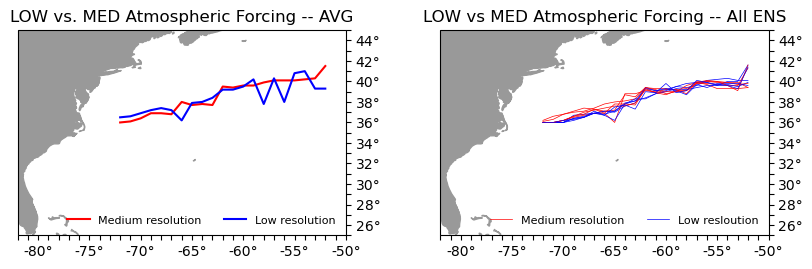

In [61]:
    fig = plt.figure(figsize=(10, 6), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, hspace=.25)
    PC = ccrs.PlateCarree()
    _LAND_50M = feature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor='#999999'
    )

    ax = fig.add_subplot(gs[0, 0], projection=PC)
    ax.add_feature(_LAND_50M)
    ax.plot(modelgsipointsmed_avg.lon-360, modelgsipointsmed_avg, c='r', label = 'Medium resolution')
    ax.plot(modelgsipointslow_avg.lon-360, modelgsipointslow_avg, c='b', label = 'Low resolution') 
    ax.plot(obsgsipts, obsgsipts, c = 'black') 
    add_ticks(ax, xlabelinterval=5)
    ax.set_extent([-82, -50, 25, 44])
    ax.set_title('LOW vs. MED Atmospheric Forcing -- AVG')
    ax.legend(ncol=4, loc='lower right', frameon=False, fontsize=8)

    ax = fig.add_subplot(gs[0, 1], projection=PC)
    ax.add_feature(_LAND_50M)
    ax.plot(modelgsipointsmed1.lon-360, modelgsipointsmed1, c='r', linewidth='.5', label = 'Medium resolution')
    ax.plot(modelgsipointslow1.lon-360, modelgsipointslow1, c='b', linewidth='.5', label = 'Low resloution') 
    ax.plot(modelgsipointsmed2.lon-360, modelgsipointsmed2, c='r', linewidth='.5')
    ax.plot(modelgsipointslow2.lon-360, modelgsipointslow2, c='b', linewidth='.5') 
    ax.plot(modelgsipointsmed3.lon-360, modelgsipointsmed3, c='r', linewidth='.5')
    ax.plot(modelgsipointslow3.lon-360, modelgsipointslow3, c='b', linewidth='.5') 
    ax.plot(modelgsipointsmed4.lon-360, modelgsipointsmed4, c='r', linewidth='.5')
    ax.plot(modelgsipointslow4.lon-360, modelgsipointslow4, c='b', linewidth='.5') 
    ax.plot(modelgsipointsmed5.lon-360, modelgsipointsmed5, c='r', linewidth='.5')
    ax.plot(modelgsipointslow5.lon-360, modelgsipointslow5, c='b', linewidth='.5') 
    add_ticks(ax, xlabelinterval=5)
    ax.legend(ncol=4, loc='lower right', frameon=False, fontsize=8)
    ax.set_extent([-82, -50, 25, 44])
    ax.set_title('LOW vs MED Atmospheric Forcing -- All ENS')

In [31]:
annual_neus_low1_corr 

-0.6148544204561895

In [32]:
annual_neus_low2_corr

0.268211134825567

In [33]:
annual_neus_low3_corr

0.5612845618999428

In [34]:
annual_neus_low4_corr

0.31501279985948893

In [35]:
annual_neus_low5_corr

0.8152443328195023

In [36]:
annual_neus_med1_corr

0.295600261649129

In [37]:
annual_neus_med2_corr

0.6924291378855106

In [38]:
annual_neus_med3_corr

-0.006552961294197049

In [39]:
annual_neus_med4_corr

0.12366835656284193

In [40]:
annual_neus_med5_corr

0.4293361196558418

In [59]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax.plot(obsgsipts, obsgsipts, c = 'black') 

<Figure size 800x600 with 0 Axes>

In [62]:
obsgsipts

time
1993-01-01    0.206436
1994-01-01    0.589553
1995-01-01    1.415258
1996-01-01   -0.344687
1997-01-01   -0.768714
1998-01-01   -0.921331
1999-01-01   -0.371093
2000-01-01    1.137956
2001-01-01   -0.322869
2002-01-01    0.253354
2003-01-01   -0.780024
2004-01-01   -0.974844
2005-01-01   -0.784724
2006-01-01   -0.142260
2007-01-01   -0.711205
2008-01-01   -0.324492
2009-01-01    0.025604
2010-01-01   -0.536280
2011-01-01   -1.067469
2012-01-01    0.290823
2013-01-01   -0.540524
2014-01-01    0.029855
2015-01-01    0.459321
2016-01-01    0.737590
2017-01-01    0.490090
2018-01-01    1.432259
2019-01-01    1.522417
Freq: YS-JAN, dtype: float64